In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append("../../")

from src.context_aware.config import ModelConfig, TrainingConfig, DatasetConfig
from src.DatasetManager import DatasetConvertor 
from src.context_aware.preprocessing import PreparingDataset
from src.context_aware.models import createModel
from src.context_aware.training import trainModel
from src.context_aware.evaluation import evaluateModel

In [2]:
rawDatasetFolder = "../../data/raw"
model_folder = "../../data/models/context_aware"

direction = "forward"
lenWindow = 20

mapping = {"forward": "fr", "backward": "bk"}
dpdr_params = [
    {"dbParameter": 0.01, "alpha": 0.01, "mode": "fixed"}
]
verbose = True

In [3]:
datasetConverter = DatasetConvertor(rawDatasetFolder)
datasetConverter.processDataset(direction=direction, **dpdr_params[0])
thumbDataUnit = datasetConverter.getDataUnit(f"thumb_{mapping[direction]}")
datasetConfig = DatasetConfig.initialize(len_window=lenWindow, data_augment=True)
trainData, testData = PreparingDataset(thumbDataUnit, datasetConfig, verbose=False)

modelConfig = ModelConfig.from_dataset(datasetConfig, trainData)
model, device = createModel(modelConfig)

trainingConfig = TrainingConfig()
model, avg_train_loss_history, avg_test_loss_history = trainModel(
    model, trainData, testData, trainingConfig, verbose=verbose
)
model.save_checkpoint(f"{model_folder}/direction_{direction}_lenWindow_{lenWindow}.pth")

========== Thumb ============
Forward: Compression rate: 0.2231
========== Index ============
Forward: Compression rate: 0.2456
========== Middle ============
Forward: Compression rate: 0.2491
Size of train loader: 8, Size of test loader: 6
Used device: cuda:0
Size of model: 31841
TrafficPredictorContextAssisted(
  (dbf2traffic): DeadFeaturesToTrafficLayer(
    (input_layer): Sequential(
      (0): Linear(in_features=231, out_features=64, bias=True)
      (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Dropout(p=0.8, inplace=False)
    )
    (hidden_layers): ModuleList(
      (0-2): 3 x Sequential(
        (0): Linear(in_features=64, out_features=64, bias=True)
        (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Dropout(p=0.8, inplace=False)
      )
    )
    (trans2transmission_layer): Linear(in_features=64, out_features=20, bias=True)
    (sigmoi

c:\Users\Ye\Documents\YuYeh_Documents\L2S\Projects\context_aware_traffic_predictor\experiments\notebooks\../..\src\base\base_model.py:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental 

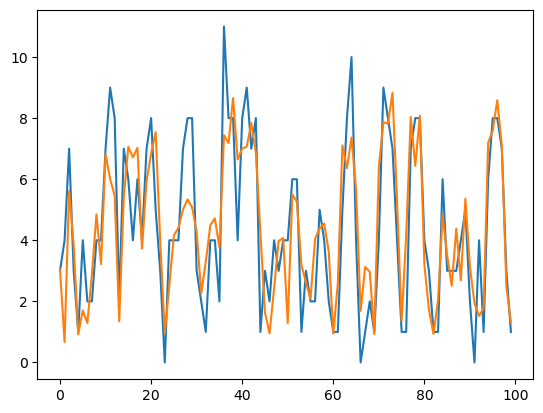

In [4]:
datasetConfig = DatasetConfig.initialize(len_window=lenWindow, data_augment=False)
_, testData = PreparingDataset(thumbDataUnit, datasetConfig, verbose=False)
model, device = createModel(modelConfig)
model.load_checkpoint(f"{model_folder}/direction_{direction}_lenWindow_{lenWindow}.pth")
results = evaluateModel(model, testData)

plt.plot(results['trafficTarget_actual'][0:100])
plt.plot(results['trafficTarget_predicted'][0:100])
plt.show()